In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline 
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score, f1_score
from sklearn.model_selection import KFold, RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.optimizers import Adam

import shap

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("online_shoppers_intention.csv")

In [3]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

In [5]:
df.Month.value_counts()

May     3364
Nov     2998
Mar     1907
Dec     1727
Oct      549
Sep      448
Aug      433
Jul      432
June     288
Feb      184
Name: Month, dtype: int64

In [6]:
# Changing the boolean datatypes into integer datatypes
df['Weekend'] = df['Weekend'].astype('int64')
df['Revenue'] = df['Revenue'].astype('int64')

In [7]:
# Changing the other categorical variables into integer datatypes using ordinal encoding
# This transforms categorical value to numerical value in ordered sets through a dictionary

Month_dict = {'Feb' : 2, 'Mar': 3, 'May': 5, 'June': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}

df['Month'] = df.Month.map(Month_dict)

VisitorType_dict = {'Other': 0, 'New_Visitor' : 1, 'Returning_Visitor': 2}

df['VisitorType'] = df.VisitorType.map(VisitorType_dict)

In [8]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,2,1,1,1,1,2,0,0
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,2,2,2,1,2,2,0,0
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,2,4,1,9,3,2,0,0
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,2,3,2,2,4,2,0,0
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,2,3,3,1,4,2,1,0


In [9]:
df.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220,0.022191,0.043073,5.889258,0.061427,7.651987,2.124006,2.357097,3.147364,4.069586,1.848824,0.232603,0.154745
std,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288,0.048488,0.048597,18.568437,0.198917,3.392841,0.911325,1.717277,2.401591,4.025169,0.376989,0.422509,0.361676
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000,0.014286,0.000000,0.000000,5.000000,2.000000,2.000000,1.000000,2.000000,2.000000,0.000000,0.000000
50%,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905,0.003112,0.025156,0.000000,0.000000,7.000000,2.000000,2.000000,3.000000,2.000000,2.000000,0.000000,0.000000
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157214,0.016813,0.050000,0.000000,0.000000,11.000000,3.000000,2.000000,4.000000,4.000000,2.000000,0.000000,0.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,12.000000,8.000000,13.000000,9.000000,20.000000,2.000000,1.000000,1.000000


In [10]:
X = df.drop('Revenue', 1)
y = df['Revenue']
columns = X.columns
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
X_std = pd.DataFrame(X_std, columns = columns)

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.2, random_state = 7 )


In [12]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(9864, 17)
(2466, 17)
(9864,)
(2466,)


In [13]:
# Convert target classes to categorical ones
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)

In [14]:
# baseline model
def create_baseline(hiddenLayerOne = 64, hiddenLayerTwo = 32, dropout = 0.5, learnRate = 0.01):
    
    # create model
    
    model = Sequential()
    model.add(Dense(hiddenLayerOne, input_shape=(17, ), activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(hiddenLayerTwo, activation = 'relu'))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=Adam(learnRate), metrics=['accuracy'])
    
    return model

In [15]:
#history = model.fit(X_train, y_train, epochs=10, batch_size=250, verbose=1, validation_split=0.2)

In [16]:
estimators = []
estimators.append(('mlp', KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)

In [17]:
np.random.seed(7)

for scoring in["accuracy", "f1"]:
    cv = StratifiedKFold(n_splits=5, shuffle = True, random_state=7)
    scores = cross_val_score(pipeline, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)
    print("Model", scoring, " mean=", scores.mean())

Model accuracy  mean= 0.8846306990209614
Model f1  mean= 0.3860847530149427


In [18]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('mlp',
                 <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f93ec024110>)])

In [19]:
y_preds = pipeline.predict(X_test)

print(accuracy_score(y_test, y_preds))
print(f1_score(y_test, y_preds))
print(classification_report(y_test, y_preds))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
0.8775344687753447
0.396
              precision    recall  f1-score   support

           0       0.88      0.99      0.93      2077
           1       0.89      0.25      0.40       389

    accuracy                           0.88      2466
   macro avg       0.88      0.62      0.66      2466
weighted avg       0.88      0.88      0.85      2466



The Multilayer Perceptron tends to predict class 0 rather than class 1, because of the imbalanced data.

In [20]:
from imblearn.over_sampling import SMOTE
pipeline_os = Pipeline([
    ('smote', SMOTE()),
    ('cl', KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=5, verbose=0))
])

In [21]:
np.random.seed(7)

for scoring in["accuracy", "f1"]:
    cv = StratifiedKFold(n_splits=5, shuffle = True, random_state=7)
    scores = cross_val_score(pipeline_os, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)
    print("Model", scoring, " mean=", scores.mean())

Model accuracy  mean= 0.8783443114911342
Model f1  mean= 0.6287704794256734


In [22]:
pipeline_os.fit(X_train, y_train)

Pipeline(steps=[('smote', SMOTE()),
                ('cl',
                 <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f93eb454850>)])

In [23]:
y_preds = pipeline_os.predict(X_test)

print(accuracy_score(y_test, y_preds))
print(f1_score(y_test, y_preds))
print(classification_report(y_test, y_preds))

0.884022708840227
0.6658878504672897
              precision    recall  f1-score   support

           0       0.95      0.91      0.93      2077
           1       0.61      0.73      0.67       389

    accuracy                           0.88      2466
   macro avg       0.78      0.82      0.80      2466
weighted avg       0.89      0.88      0.89      2466



The results show that the use of oversampling helps the Multilayer Perceptron model to predict the class 1 better. 

In [24]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=7)

In [25]:
param_grid = {'cl__hiddenLayerOne':[64, 128, 256],
              'cl__hiddenLayerTwo':[16, 32, 64],
              'cl__learnRate':[1e-2, 1e-3, 1e-4],
              'cl__dropout':[0.3, 0.4, 0.5],
              'cl__batch_size':[10, 20, 40, 60, 80, 100, 120, 140, 160],
              'cl__epochs': [10, 50, 100, 150]}
    



In [26]:
np.random.seed(11)

grid = RandomizedSearchCV(estimator=pipeline_os, n_jobs=-1, cv=cv, param_distributions=param_grid, scoring="accuracy")


In [27]:
np.random.seed(11)

grid_result = grid.fit(X_train, y_train)

In [28]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
#print("Best: %f " % (f1_grid_result.best_score_))

Best: 0.864659 using {'cl__learnRate': 0.001, 'cl__hiddenLayerTwo': 32, 'cl__hiddenLayerOne': 128, 'cl__epochs': 50, 'cl__dropout': 0.3, 'cl__batch_size': 40}


In [29]:
test_score = grid_result.score(X_test, y_test)
print(f'Cross-validation score: {grid_result.best_score_}\nTest score: {test_score}')

Cross-validation score: 0.8646586079072205
Test score: 0.8767234387672344


In [30]:
#Test results after the model is trained with oversampling and GridSearchCV
pred_test = grid_result.predict(X_test)
print(accuracy_score(y_test, pred_test))
print(f1_score(y_test, pred_test))
print(classification_report(y_test, pred_test))

0.8767234387672344
0.6752136752136751
              precision    recall  f1-score   support

           0       0.96      0.89      0.92      2077
           1       0.58      0.81      0.68       389

    accuracy                           0.88      2466
   macro avg       0.77      0.85      0.80      2466
weighted avg       0.90      0.88      0.88      2466



For fold 1:


Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


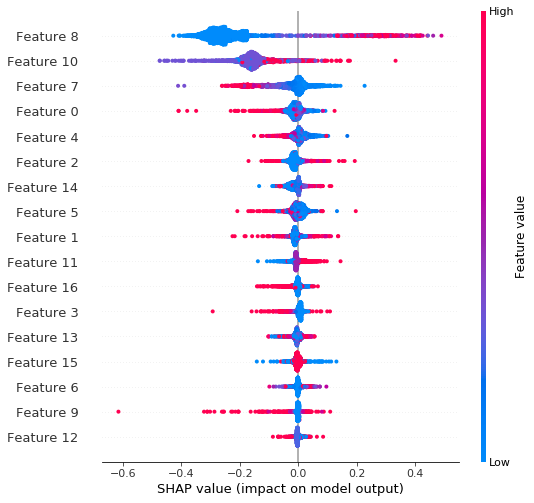

For fold 2:


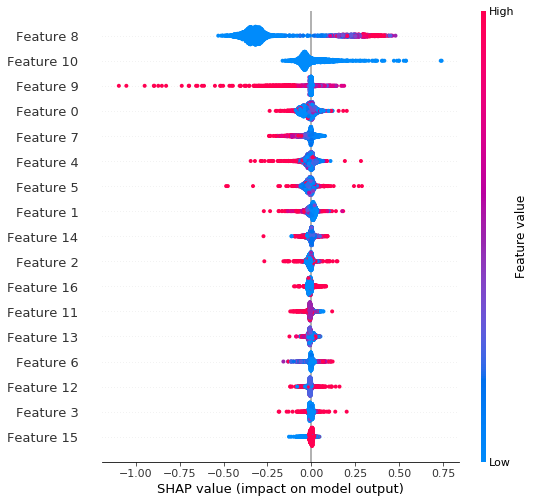

For fold 3:


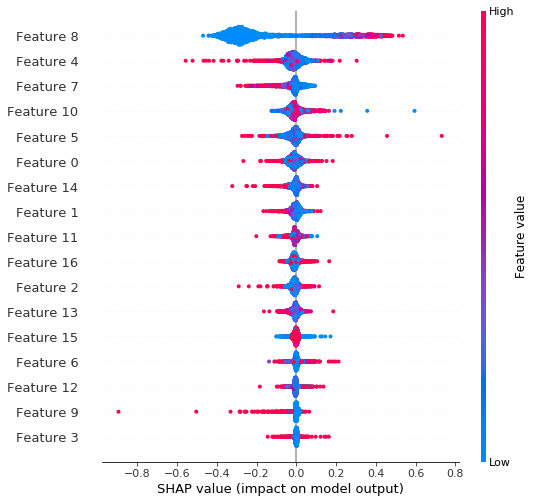

For fold 4:


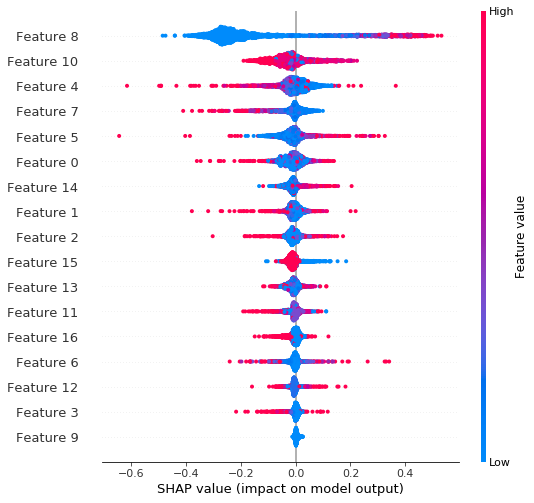

For fold 5:


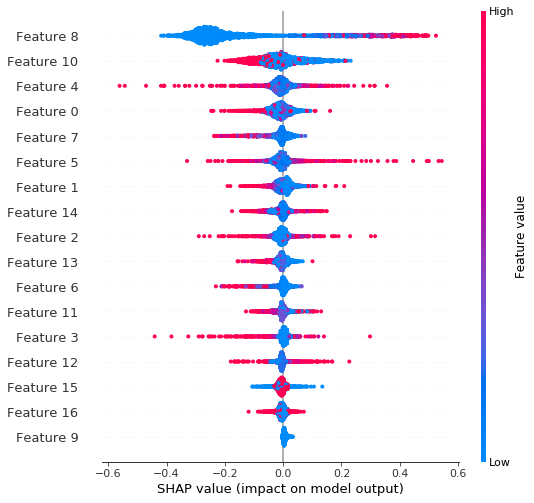

In [31]:
#SHAP values with oversampling the training data and the tuned hyperparameters
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score
os = SMOTE(random_state = 7)

kf = KFold(n_splits=5)

for fold, (train_index, test_index) in enumerate(kf.split(X_std, y), 1):
    X_train = X_std.iloc[train_index, :]
    y_train = y[train_index] 
    X_test = X_std.iloc[test_index, :]
    y_test = y[test_index]  # See comment on ravel and  y_train
    X_train_oversampled, y_train_oversampled = os.fit_resample(X_train, y_train)
    model = Sequential()
    model.add(Dense(256, input_dim=17, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation = 'relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(loss="binary_crossentropy", optimizer = Adam(0.001), metrics = ['accuracy'])
    model.fit(X_train_oversampled, y_train_oversampled, epochs=100, batch_size=80, verbose=0)  
    print(f'For fold {fold}:')
    shap.initjs()
    data_for_prediction = X_test.values.astype('float')
    background = X_train_oversampled.values.astype('float')
    explainer = shap.DeepExplainer(model, background)
    shap_values = explainer.shap_values(data_for_prediction)
    shap.summary_plot(shap_values[0], data_for_prediction)
    

The accuracy score for the first fold is the highest, indicating that PageValues, Month, and ExitRates are the most important features.